# Test CTGAN training with data with missing samples

This notebook tests whether the CTGAN model can be trained with a dataset with missing data.

In [1]:
import numpy as np
import pandas as pd

import sdv
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

## Single numeric column

### Create a synthetic *real* dataset

In [2]:
n = 100
n_missing = 20
col_num_nan = np.empty(n_missing)
col_num_nan[:] = np.nan
col_num = np.concatenate([np.random.randn(n-n_missing), col_num_nan])
col_num = np.random.permutation(col_num)

real_data = pd.DataFrame(col_num, columns=['col_num'])

Note that the metadata can be inferred from a pandas dataframe.

### Create metadata

In [3]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)

In [4]:
metadata

{
    "columns": {
        "col_num": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}

### Train the synthesizer model and generatee synthetic samples

In [5]:
%%time

synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(real_data)

/opt/anaconda3/envs/sdv/lib/python3.12/site-packages/sdv/single_table/base.py:86: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
CPU times: user 38.4 s, sys: 27 s, total: 1min 5s
Wall time: 10.5 s


The loss function confirms that the model is trained

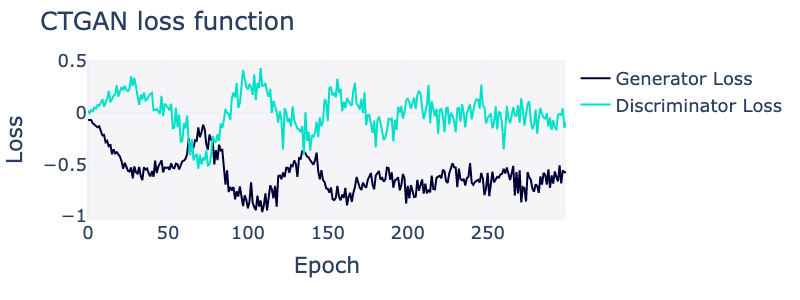

In [6]:
fig = synthesizer.get_loss_values_plot()
fig.show("png", width=800, height=300)

In [7]:
%%time
synthetic_data = synthesizer.sample(num_rows=500)

CPU times: user 65.7 ms, sys: 165 ms, total: 230 ms
Wall time: 77.8 ms


In [8]:
synthetic_data.head()

,col_num
0,0.954353
1,NaN
2,-0.774331
3,0.015902
4,1.640887


### Run diagnostics on the synthetic data

In [9]:
diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |███████████████| 1/1 [00:00<00:00, 256.53it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████████| 1/1 [00:00<00:00, 286.44it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



As expected, the correlation-based diagnostic fails (returns `nan%`)

In [10]:
quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |████████████████| 1/1 [00:00<00:00, 56.01it/s]|
Column Shapes Score: 81.22%

(2/2) Evaluating Column Pair Trends: |                   | 0/0 [00:00<?, ?it/s]|
Column Pair Trends Score: nan%

Overall Score (Average): 81.22%

